In [1]:
!pip install lime
!pip install shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import seaborn as sns

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_data(annotation_file, physiological_file):
    # Read annotation data
    annotation_data = pd.read_csv(annotation_file)

    # Classify emotion based on valence and arousal
    def classify_emotion(arousal, valence):
        arousal_bins = [-26225, -13112, 0, 13112, 26225]
        valence_bins = [-26225, -13112, 0, 13112, 26225]

        arousal_label = pd.cut([arousal], bins=arousal_bins,
                               labels=False, include_lowest=True)
        valence_label = pd.cut([valence], bins=valence_bins,
                               labels=False, include_lowest=True)

        return f'Partition_{arousal_label}_{valence_label}'
    
    annotation_data = annotation_data[annotation_data['video'].isin([1.0, 2.0])]

    annotation_data['Emotion_Partition'] = annotation_data.apply(
        lambda row: classify_emotion(row['arousal'], row['valence']), axis=1)

    # Define the rectangular partition
    rectangular_partition = {
        'arousal': (-3000, 3000), 'valence': (-3000, 3000)}
    
    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data['Emotion'] = ''

    for index, row in annotation_data.iterrows():
        arousal = row['arousal']
        valence = row['valence']

        if -3000 <= arousal <= 3000 and -3000 <= valence <= 3000:
            annotation_data.loc[index, 'Emotion'] = 'Neutral'
        else:
            if -26225 <= arousal <= -13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Anxious or Dejected'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tired or Bored'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index, 'Emotion'] = 'Polite or Sleepy'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Relaxed or Calm'
            elif -13112 <= arousal <= 0:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index, 'Emotion'] = 'Miserable or Sad'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Worried or Apathetic'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Confident or Attentive'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Pleased or Glad'
            elif 0 <= arousal <= 13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Discontented'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Impatient'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Passionate or Amused'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Delighted or Happy'
            else:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Distressed or Defiant'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tensed or Annoyed'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Aroused or Astonished'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Excited or Adventurous'
                    
    # Scatter plot with color-coded partitions
    c = annotation_data['Emotion_Partition'].astype('category').cat.codes
    plt.scatter(annotation_data['valence'], annotation_data['arousal'],
                c=c, cmap='viridis', label='Other Partitions')

    # Draw vertical lines for Arousal partitions
    arousal_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in arousal_bins[1:-1]:
        plt.axvline(x=bin_value, color='black', linestyle='--', linewidth=1)

    # Draw horizontal lines for Valence partitions
    valence_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in valence_bins[1:-1]:
        plt.axhline(y=bin_value, color='black', linestyle='--', linewidth=1)

    # Create a mask for points inside the rectangular partition
    mask = (
        (annotation_data['arousal'] >= rectangular_partition['arousal'][0]) &
        (annotation_data['arousal'] <= rectangular_partition['arousal'][1]) &
        (annotation_data['valence'] >= rectangular_partition['valence'][0]) &
        (annotation_data['valence'] <= rectangular_partition['valence'][1])
    )

    # Scatter plot for points inside the rectangular partition with a different color
    plt.scatter(annotation_data.loc[mask,
                'valence'], annotation_data.loc[mask, 'arousal'], c='red', label='Rectangular Partition')

    plt.title(
        'Emotion Partitions based on Arousal and Valence with Extra Partition Rectangle')
    plt.xlabel('Arousal')
    plt.ylabel('Valence')
    plt.legend()
    plt.show()

    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data_1 = annotation_data.drop('Emotion_Partition', axis=1)
    physiological_data = pd.read_csv(physiological_file)
    # Assuming you have a DataFrame named 'merged_data' with columns 'video_x', 'video_y', and 'time'

    annotation_data_1['jstime'] = annotation_data_1['jstime'].astype('int')
    physiological_data['daqtime'] = physiological_data['daqtime'].astype('int')

    annotation_data_1.rename(columns={"jstime": "time"}, inplace=True)

    physiological_data.rename(columns={"daqtime": "time"}, inplace=True)

    merged_data = pd.merge(
        annotation_data_1, physiological_data, on="time", how="left")

    return merged_data

# merged_data = preprocess_data(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_annotation/sub_{subject}.csv',
#                               f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_physiological/sub_{subject}.csv')
    

In [3]:
# print(X_test[0:100])
# np.array(shap_values_RF_test).shape

Creating legend with loc="best" can be slow with large amounts of data.


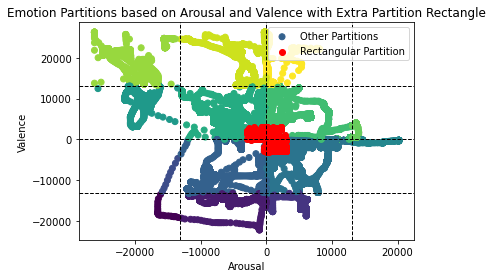

['Frustrated or Impatient' 'Tensed or Annoyed' 'Distressed or Defiant'
 'Confident or Attentive' 'Passionate or Amused' 'Aroused or Astonished'
 'Worried or Apathetic' 'Polite or Sleepy' 'Tired or Bored'
 'Pleased or Glad' 'Anxious or Dejected' 'Miserable or Sad'
 'Frustrated or Discontented' 'Delighted or Happy']
        valence  arousal  video_x                  Emotion      ecg  \
1353    -1848.0   3040.0      1.0  Frustrated or Impatient  0.68834   
1356    -1848.0   3156.0      1.0  Frustrated or Impatient  0.85918   
1359    -1848.0   3188.0      1.0  Frustrated or Impatient  0.66206   
1362    -1848.0   3252.0      1.0  Frustrated or Impatient  0.62592   
1365    -1848.0   3272.0      1.0  Frustrated or Impatient  0.01154   
...         ...      ...      ...                      ...      ...   
226573   -296.0 -12547.0      1.0     Worried or Apathetic  0.96432   
226574   -296.0 -12547.0      1.0     Worried or Apathetic  0.97088   
226575   -296.0 -12511.0      1.0     Worried

In [4]:
#FOR 20-24 AGE CATEGORY all merged

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Preprocess data for the current subject
merged_data_1 = preprocess_data(
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/amusing_25-29_annotations.csv',
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/amusing_25-29_physiological.csv'
)
    

merged_data_1['valence'] = merged_data_1['valence'].fillna(method="ffill")
merged_data_1['arousal'] = merged_data_1['arousal'].fillna(method="ffill")
merged_data_1 = merged_data_1[merged_data_1['video_x'] == merged_data_1['video_y']]
merged_data_1 = merged_data_1[merged_data_1['Emotion'] != 'Neutral']
sub_data = merged_data_1.drop('time', axis=1)
print(sub_data['Emotion'].unique())
print(sub_data)
print(len(sub_data))
label_encoder = LabelEncoder()
X=sub_data.drop(['Emotion','valence','arousal','video_y','video_x'],axis=1)
y=sub_data['Emotion']
y_encoded = label_encoder.fit_transform(sub_data['Emotion'])
encoded_classes = label_encoder.classes_
y = y_encoded

print(len(X))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)





TIME to interpret

 118.36471605300903 seconds


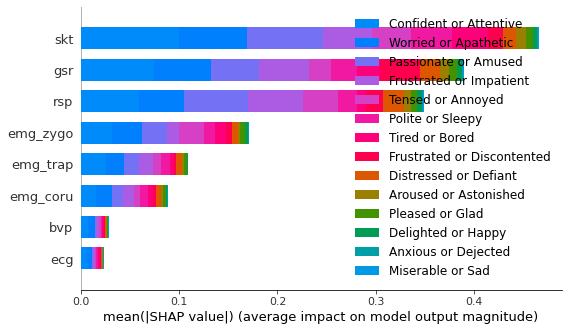

In [5]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
t0 = time.time()
explainerRF = shap.TreeExplainer(rf)
shap_values_RF_test = explainerRF.shap_values(X_test[0:100])
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()

class_names = encoded_classes
shap.summary_plot(shap_values_RF_test, X_test,class_names=class_names)


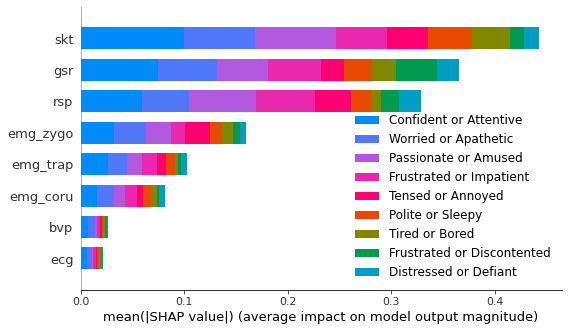

In [6]:
# Step 1: Sum the absolute SHAP values across features for each class
class_sums = np.sum(np.abs(shap_values_RF_test), axis=(1, 2))

# Step 2: Get the indices of the top N classes
top_class_indices = np.argsort(class_sums)[-9:]  # Change 6 to the number of classes you want to display

# Step 3: Select the SHAP values and class names for these top classes
shap_values_top_classes = [shap_values_RF_test[i] for i in top_class_indices]
class_names_top = [class_names[i] for i in top_class_indices]

# Step 4: Create the summary plot for the top classes
shap.summary_plot(shap_values_top_classes, X_test[0:100], class_names=class_names_top)


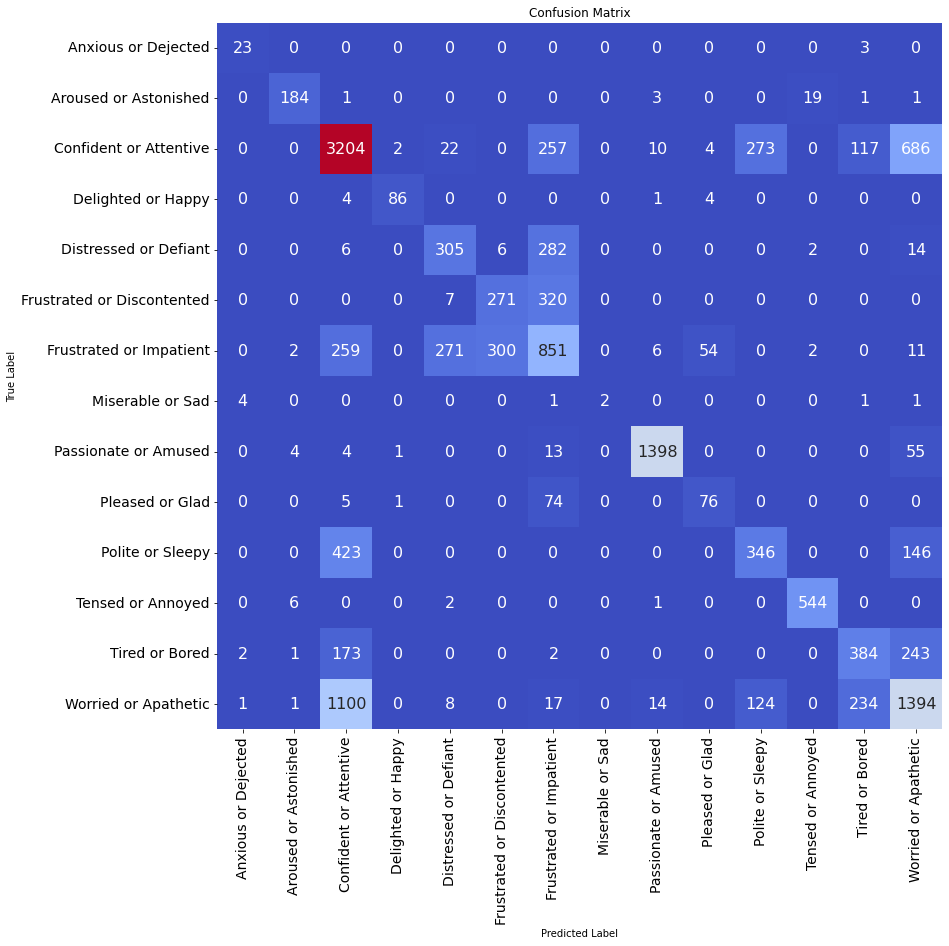

<Figure size 432x288 with 0 Axes>

In [7]:

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Extract unique labels from y_test
unique_labels = sorted(set(y_test))

# Create a filtered list of class names
filtered_class_names = [class_names[i] for i in unique_labels]

plt.figure(figsize=(13, 13))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names,
            annot_kws={"size": 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
plt.savefig("amusing_confusion_matrix.png", bbox_inches='tight', dpi=300)


0.6177111716621253


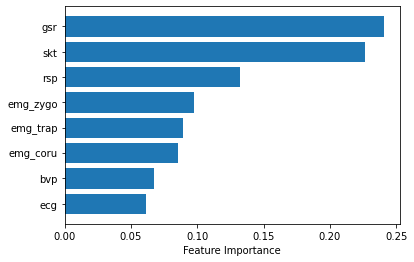

In [8]:
print(accuracy_score(y_test,y_pred))
feature_importances = rf.feature_importances_

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plotting the feature importances
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

In [25]:
instance_indices = []
for i in range(1000):
    if y_test[i]==2:
        print(X_test.iloc[i])
        print(y_test[i])
        print(i)
        instance_indices.append(i)

ecg          0.793480
bvp         35.557202
gsr         19.969344
rsp         38.828584
skt         25.308717
emg_zygo     6.425750
emg_coru     8.889750
emg_trap    15.419500
Name: 184605, dtype: float64
2
3
ecg          0.773760
bvp         37.358786
gsr         18.766872
rsp         27.009986
skt         30.514769
emg_zygo     7.904250
emg_coru     8.356000
emg_trap   -72.178250
Name: 164220, dtype: float64
2
8
ecg          0.763900
bvp         36.554839
gsr         31.615728
rsp         41.964761
skt         25.147443
emg_zygo     5.070500
emg_coru     6.466750
emg_trap    13.037750
Name: 119211, dtype: float64
2
10
ecg          0.763900
bvp         36.438625
gsr         19.374024
rsp         41.780803
skt         31.184364
emg_zygo    25.892000
emg_coru     7.657750
emg_trap     7.000750
Name: 65690, dtype: float64
2
12
ecg          0.931460
bvp         33.494122
gsr         18.837840
rsp         39.457764
skt         33.683971
emg_zygo     5.152500
emg_coru     5.809750
emg_trap 

2
522
ecg          1.043160
bvp         36.884201
gsr         11.413992
rsp         35.373045
skt         24.583016
emg_zygo     5.440000
emg_coru     5.604250
emg_trap     6.138250
Name: 73244, dtype: float64
2
532
ecg          0.990600
bvp         35.780020
gsr         18.975816
rsp         37.821944
skt         25.389343
emg_zygo     5.974000
emg_coru     9.136250
emg_trap    15.542750
Name: 170110, dtype: float64
2
541
ecg          0.839460
bvp         35.721883
gsr         26.234088
rsp         32.256254
skt         25.596180
emg_zygo     5.522250
emg_coru     6.056000
emg_trap     6.466750
Name: 187374, dtype: float64
2
544
ecg          0.836180
bvp         36.535500
gsr         11.611128
rsp         35.479519
skt         24.579516
emg_zygo     6.261500
emg_coru     5.440000
emg_trap     6.056000
Name: 72504, dtype: float64
2
547
ecg          0.803320
bvp         34.995413
gsr         18.924576
rsp         41.596905
skt         26.248255
emg_zygo     5.358000
emg_coru    13.44825

2
809
ecg          0.691620
bvp         36.031847
gsr         26.506128
rsp         33.127372
skt         25.557617
emg_zygo     5.522250
emg_coru     6.220250
emg_trap     6.549000
Name: 188895, dtype: float64
2
813
ecg          0.892040
bvp         35.373182
gsr          7.869648
rsp         42.013137
skt         28.158893
emg_zygo     5.234750
emg_coru     7.370250
emg_trap     9.588000
Name: 85556, dtype: float64
2
817
ecg          0.901900
bvp         35.964040
gsr         11.402184
rsp         35.373045
skt         24.583016
emg_zygo     5.234750
emg_coru     5.686500
emg_trap     6.138250
Name: 218047, dtype: float64
2
828
ecg          0.780340
bvp         36.031847
gsr         25.508664
rsp         33.156421
skt         25.501533
emg_zygo     5.111500
emg_coru     5.974000
emg_trap     6.877500
Name: 189879, dtype: float64
2
832
ecg          0.724480
bvp         37.736556
gsr          8.421624
rsp         41.955039
skt         28.179914
emg_zygo     5.316750
emg_coru     8.3560

2
998


In [10]:
instance_index = 3
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])
for i in range(len(class_names)):
    print(class_names[i])
    print(shap_values_RF_test[i][instance_index][:])

ecg          0.793480
bvp         35.557202
gsr         19.969344
rsp         38.828584
skt         25.308717
emg_zygo     6.425750
emg_coru     8.889750
emg_trap    15.419500
Name: 184605, dtype: float64
Confident or Attentive
Anxious or Dejected
[-1.29507953e-04 -4.62552722e-05 -7.36574732e-04  9.44326872e-04
 -1.64777866e-03  1.42831727e-04  3.90815462e-05  1.32119539e-05]
Aroused or Astonished
[-8.51547786e-05  2.07184858e-04  7.77299737e-04 -2.72271909e-03
 -1.32518042e-02  1.16684573e-03  2.73549996e-03 -1.57481483e-03]
Confident or Attentive
[-2.43149512e-04 -6.47059642e-03  1.74145719e-01  1.36968347e-01
  2.47689587e-01  2.45834977e-02  3.75515510e-02  6.64598316e-02]
Delighted or Happy
[-1.88358454e-05  3.30042853e-04 -2.30911026e-03 -1.95900203e-03
 -1.42868906e-03  3.54209903e-04 -1.17166668e-03 -5.94578271e-04]
Distressed or Defiant
[-0.00039052  0.00049342 -0.01126463 -0.02270968 -0.0124589   0.00214712
  0.00231235  0.00109339]
Frustrated or Discontented
[ 0.00072344  0.

In [11]:
colour_scheme = 'cool'

FOR  Anxious or Dejected


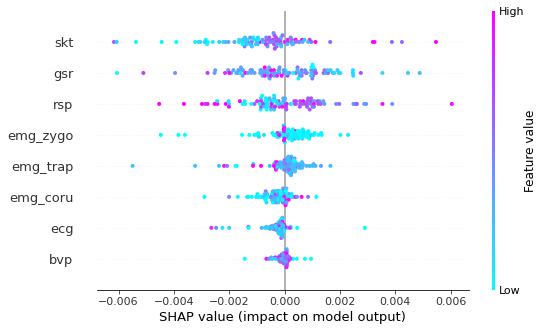

<Figure size 432x288 with 0 Axes>

FOR  Aroused or Astonished


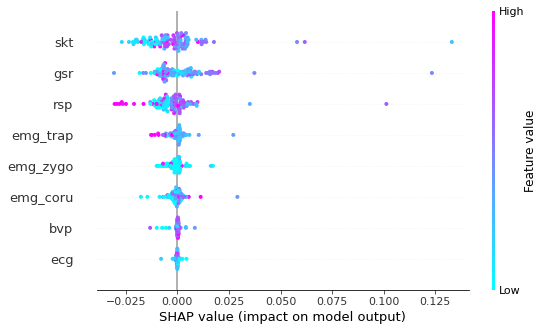

<Figure size 432x288 with 0 Axes>

FOR  Confident or Attentive


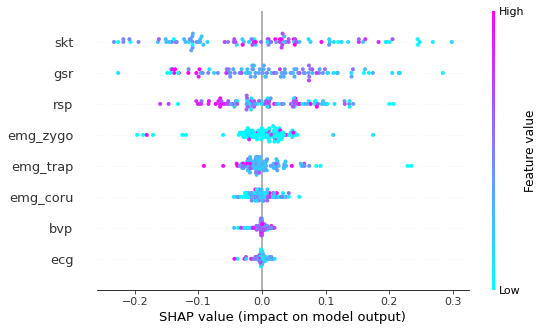

<Figure size 432x288 with 0 Axes>

FOR  Delighted or Happy


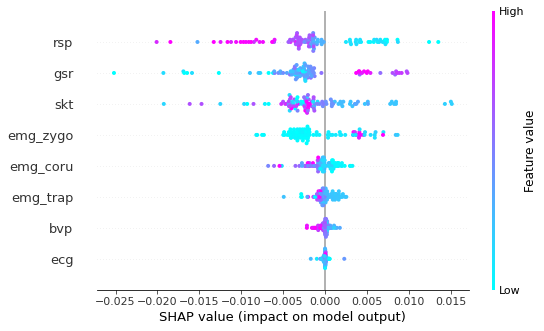

<Figure size 432x288 with 0 Axes>

FOR  Distressed or Defiant


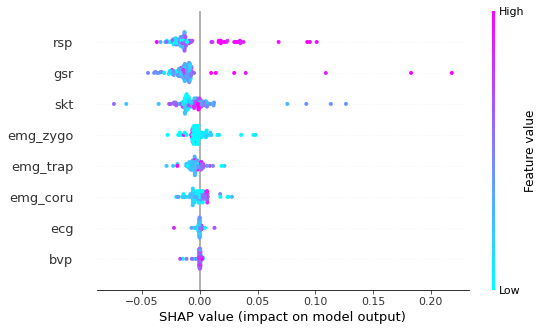

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Discontented


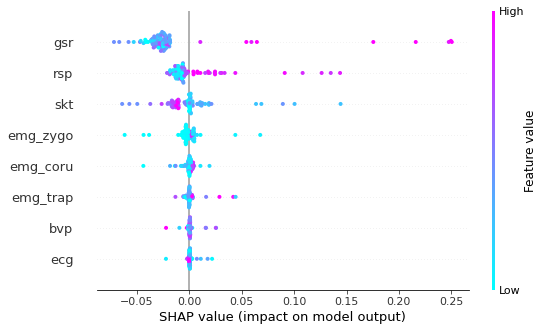

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Impatient


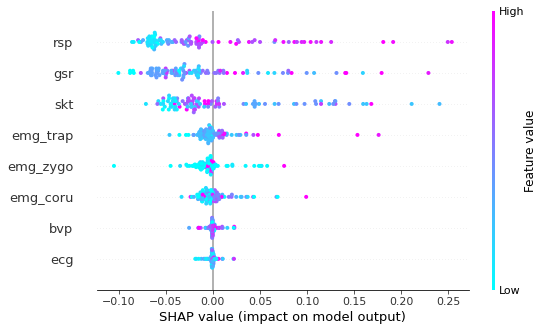

<Figure size 432x288 with 0 Axes>

FOR  Miserable or Sad


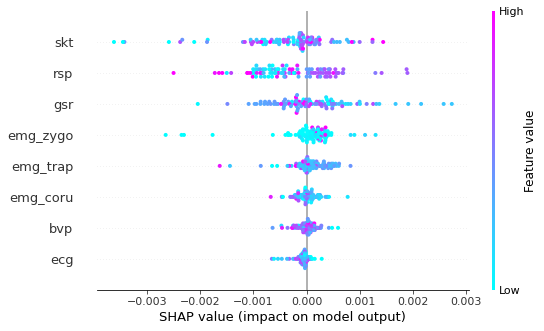

<Figure size 432x288 with 0 Axes>

FOR  Passionate or Amused


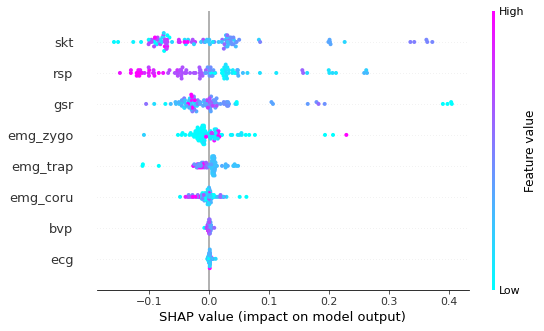

<Figure size 432x288 with 0 Axes>

FOR  Pleased or Glad


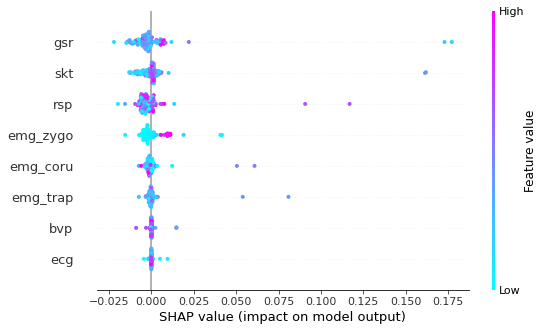

<Figure size 432x288 with 0 Axes>

FOR  Polite or Sleepy


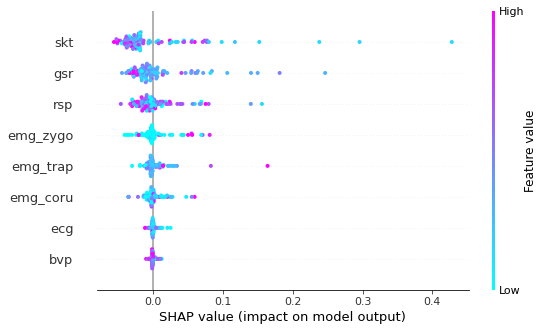

<Figure size 432x288 with 0 Axes>

FOR  Tensed or Annoyed


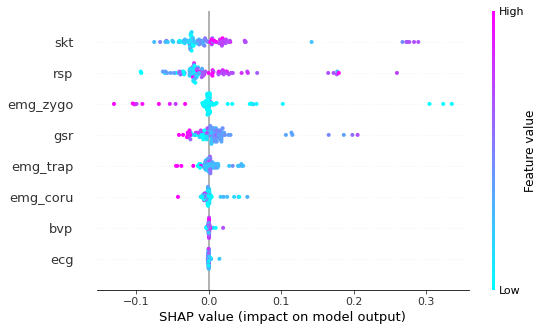

<Figure size 432x288 with 0 Axes>

FOR  Tired or Bored


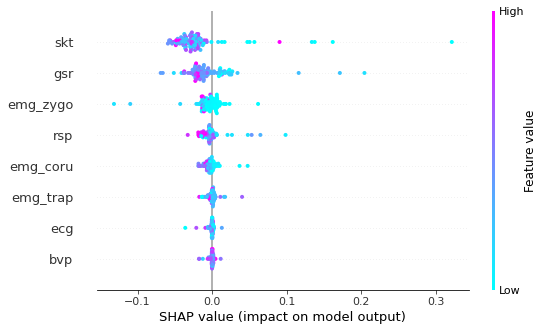

<Figure size 432x288 with 0 Axes>

FOR  Worried or Apathetic


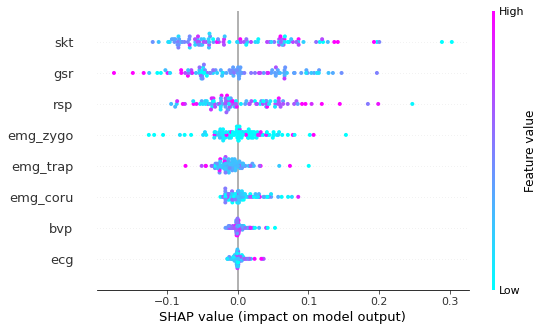

<Figure size 432x288 with 0 Axes>

In [12]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,cmap=colour_scheme)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png', bbox_inches='tight')
    plt.show()

FOR  Anxious or Dejected


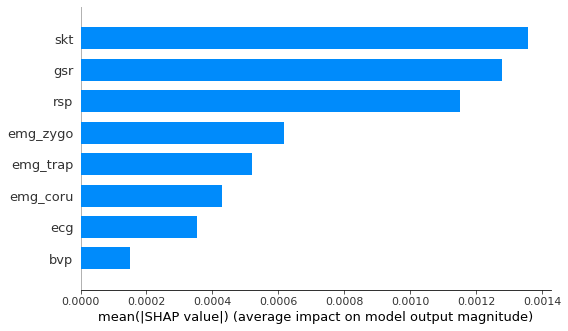

FOR  Aroused or Astonished


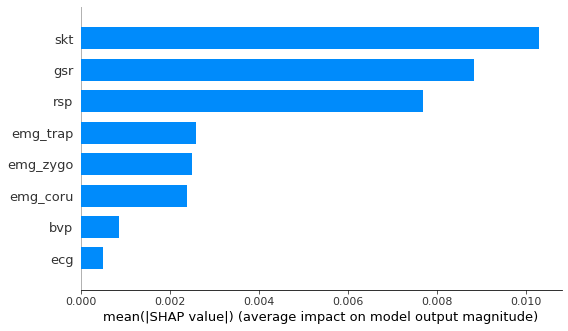

FOR  Confident or Attentive


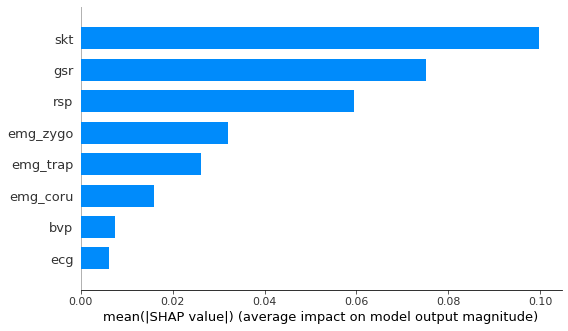

FOR  Delighted or Happy


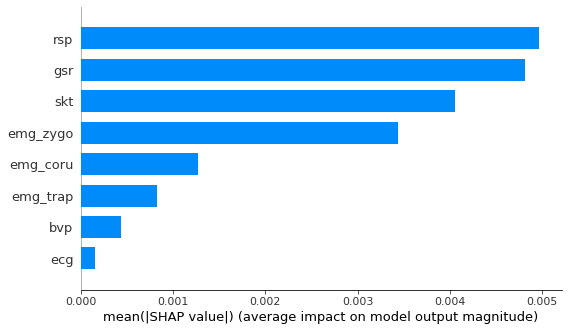

FOR  Distressed or Defiant


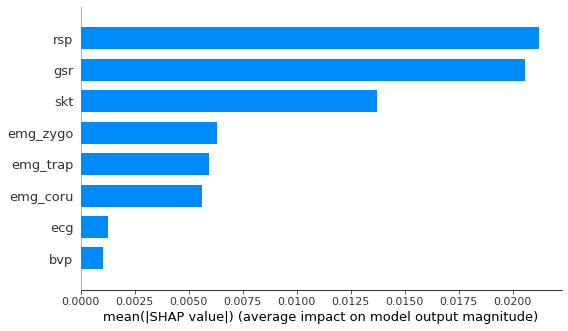

FOR  Frustrated or Discontented


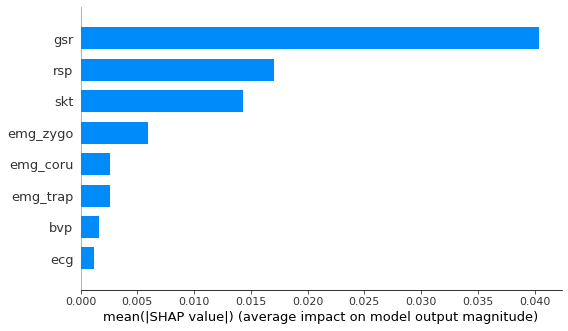

FOR  Frustrated or Impatient


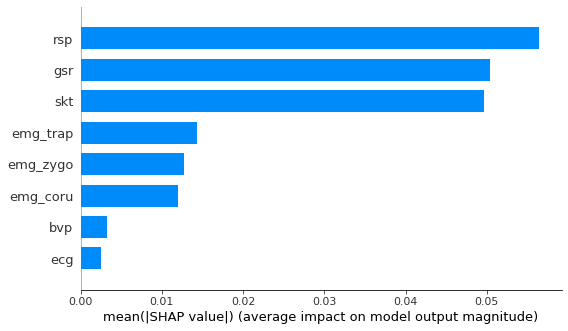

FOR  Miserable or Sad


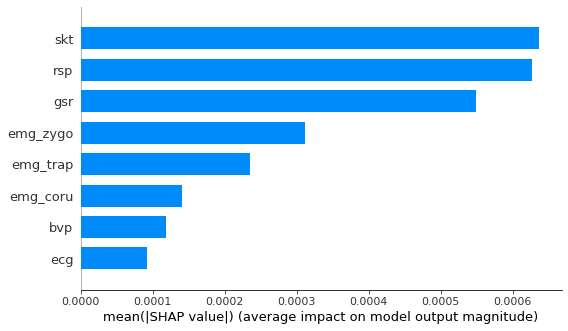

FOR  Passionate or Amused


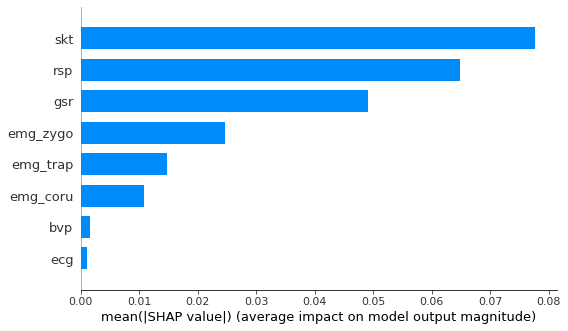

FOR  Pleased or Glad


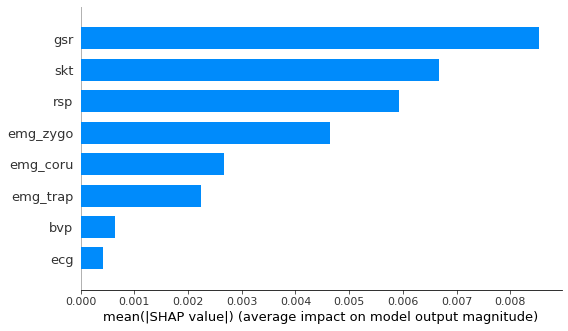

FOR  Polite or Sleepy


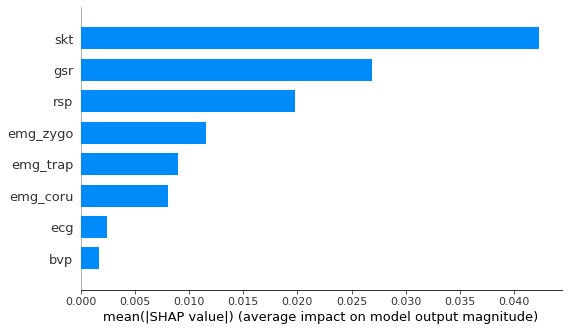

FOR  Tensed or Annoyed


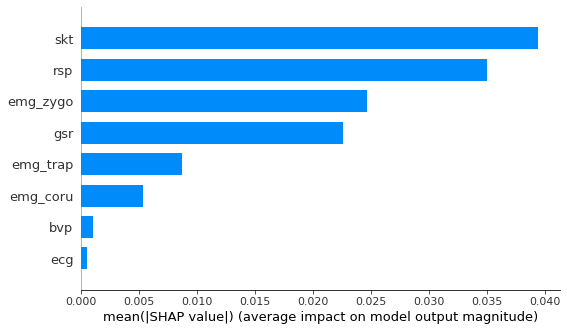

FOR  Tired or Bored


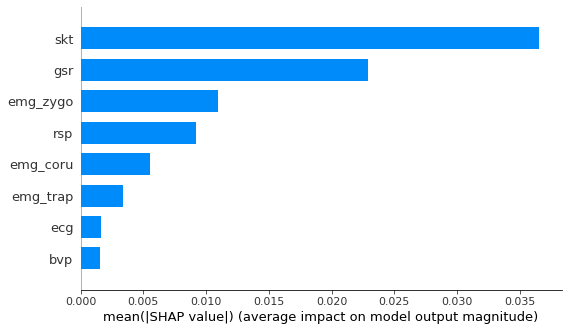

FOR  Worried or Apathetic


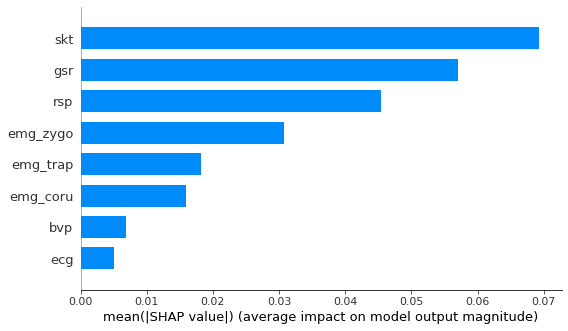

<Figure size 432x288 with 0 Axes>

In [13]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,plot_type="bar")

plt.tight_layout()

# Save or show the plot
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.show()

In [34]:
shap.initjs()
instance_index = 30
from IPython.display import display
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])

for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index][:], X_test.iloc[[instance_index]], plot_cmap="GnPR"))
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][:][:], X_test.iloc[0:100],plot_cmap="GnPR"))

ecg          0.783620
bvp         35.847767
gsr         20.548896
rsp         41.858287
skt         30.914422
emg_zygo    58.705250
emg_coru     6.672000
emg_trap     6.549000
Name: 62825, dtype: float64
Confident or Attentive
CLASS  Anxious or Dejected


CLASS  Anxious or Dejected


CLASS  Aroused or Astonished


CLASS  Aroused or Astonished


CLASS  Confident or Attentive


CLASS  Confident or Attentive


CLASS  Delighted or Happy


CLASS  Delighted or Happy


CLASS  Distressed or Defiant


CLASS  Distressed or Defiant


CLASS  Frustrated or Discontented


CLASS  Frustrated or Discontented


CLASS  Frustrated or Impatient


CLASS  Frustrated or Impatient


CLASS  Miserable or Sad


CLASS  Miserable or Sad


CLASS  Passionate or Amused


CLASS  Passionate or Amused


CLASS  Pleased or Glad


CLASS  Pleased or Glad


CLASS  Polite or Sleepy


CLASS  Polite or Sleepy


CLASS  Tensed or Annoyed


CLASS  Tensed or Annoyed


CLASS  Tired or Bored


CLASS  Tired or Bored


CLASS  Worried or Apathetic


CLASS  Worried or Apathetic


In [27]:
import time
start = time.time()
explanation = explainerRF(X_test[0:100])
end = time.time()
print(end-start)

107.85512256622314


In [28]:
# shap.plots.force(explanation[0])
np.array(explanation).shape
print(X_test)
feature_names = ['ecg','bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap']

            ecg        bvp        gsr        rsp        skt  emg_zygo  \
99513   0.68834  36.448295  33.772320  47.762725  29.645336   5.39900   
101521  0.76062  35.634679  20.706600  42.322895  30.907400  64.24950   
199426  0.96104  36.293343  19.547496  40.832261  28.954699   4.49550   
184605  0.79348  35.557202  19.969344  38.828584  25.308717   6.42575   
34153   0.72776  37.174766  11.303616  42.477745  28.158893   5.19375   
...         ...        ...        ...        ...        ...       ...   
112154  0.73762  37.320048  52.558944  46.397951  28.162393   4.82400   
33761   0.57006  35.431319  10.787136  41.955039  28.158893   5.39900   
172000  0.85262  36.864803  26.403624  30.949519  25.533075   5.07050   
109267  1.25344  36.235206  40.482648  47.636925  26.535718   6.13825   
220098  0.93146  38.424230  15.301368  32.362728  24.043132   4.94725   

        emg_coru  emg_trap  
99513    6.46675   5.56325  
101521   6.42575   6.75425  
199426   5.64550   6.34350  
184605 

In [32]:
print(instance_indices)

[3, 8, 10, 12, 13, 16, 17, 22, 23, 26, 30, 31, 42, 43, 47, 49, 50, 52, 61, 63, 65, 68, 69, 72, 76, 77, 79, 85, 88, 89, 97, 98, 99, 101, 121, 124, 133, 137, 140, 150, 153, 155, 157, 161, 162, 164, 165, 171, 172, 176, 179, 185, 192, 193, 197, 200, 211, 217, 220, 236, 238, 240, 247, 248, 251, 254, 255, 256, 257, 258, 262, 267, 273, 274, 275, 277, 279, 282, 284, 286, 289, 308, 309, 312, 320, 321, 325, 337, 338, 341, 347, 348, 350, 351, 352, 356, 357, 360, 364, 365, 367, 370, 375, 380, 383, 385, 386, 388, 389, 392, 395, 396, 397, 400, 401, 403, 405, 416, 417, 420, 421, 422, 431, 433, 441, 442, 445, 447, 449, 452, 456, 462, 467, 469, 471, 472, 474, 476, 477, 484, 485, 486, 487, 493, 499, 500, 501, 502, 503, 504, 505, 507, 509, 510, 511, 514, 515, 516, 520, 521, 522, 532, 541, 544, 547, 554, 555, 556, 561, 562, 563, 568, 573, 576, 577, 584, 588, 589, 593, 599, 601, 602, 604, 608, 620, 623, 628, 630, 632, 638, 644, 645, 647, 650, 652, 656, 658, 659, 662, 664, 666, 669, 671, 674, 680, 690, 691,

INSTANCE :  3
CLASS NAME  Confident or Attentive


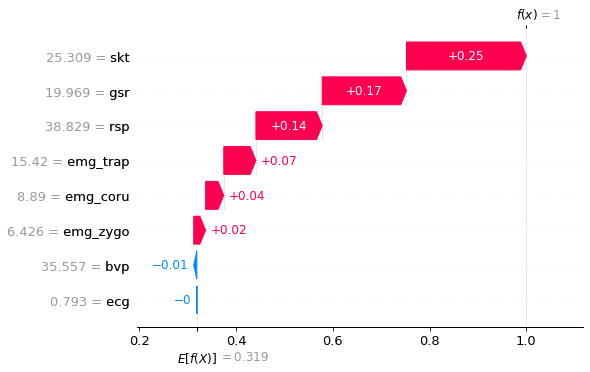

INSTANCE :  8
CLASS NAME  Confident or Attentive


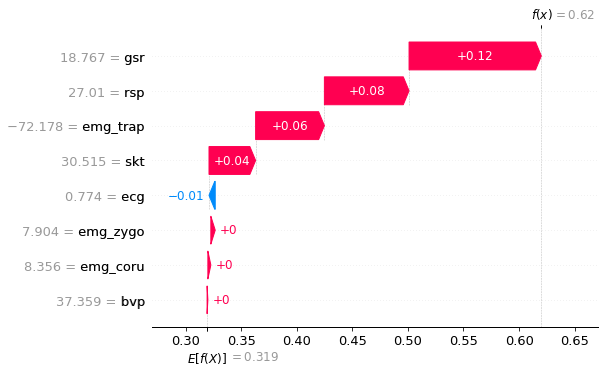

INSTANCE :  10
CLASS NAME  Confident or Attentive


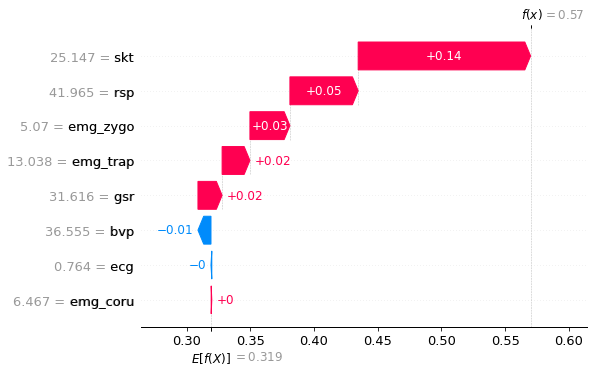

INSTANCE :  12
CLASS NAME  Confident or Attentive


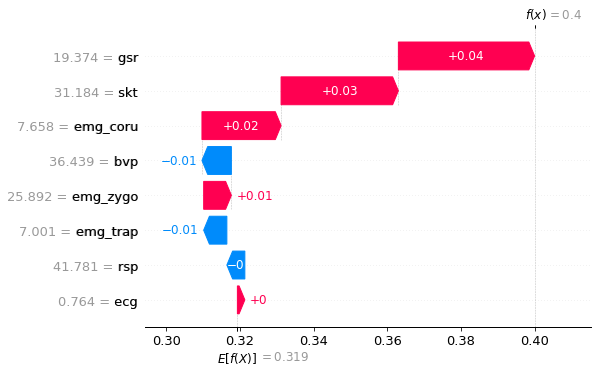

INSTANCE :  13
CLASS NAME  Confident or Attentive


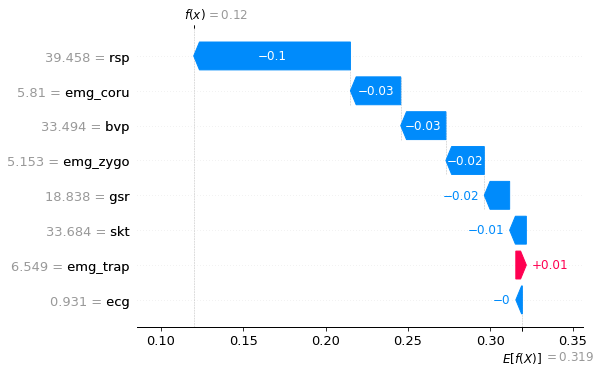

INSTANCE :  16
CLASS NAME  Confident or Attentive


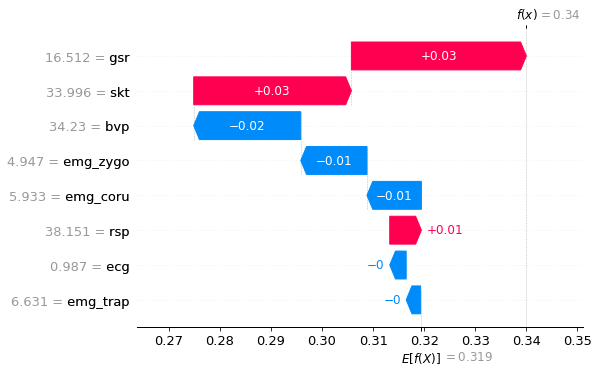

INSTANCE :  17
CLASS NAME  Confident or Attentive


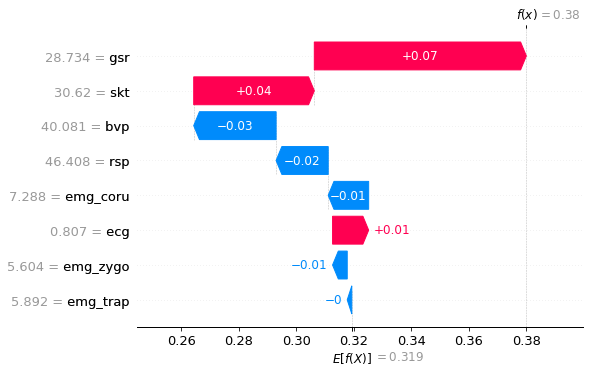

INSTANCE :  22
CLASS NAME  Confident or Attentive


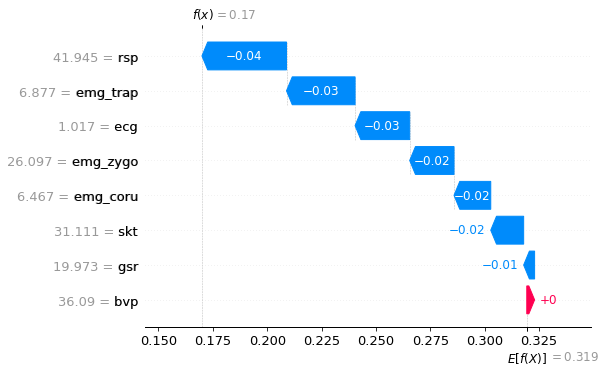

INSTANCE :  23
CLASS NAME  Confident or Attentive


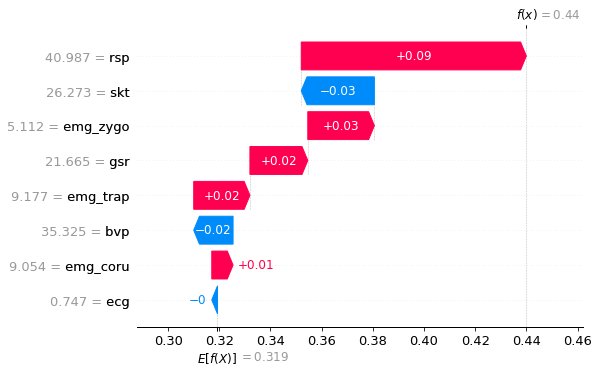

INSTANCE :  26
CLASS NAME  Confident or Attentive


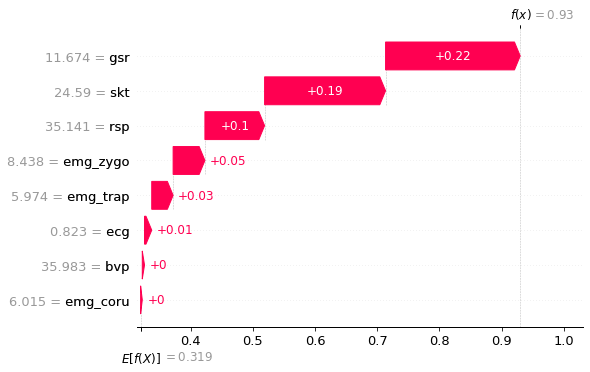

INSTANCE :  30
CLASS NAME  Confident or Attentive


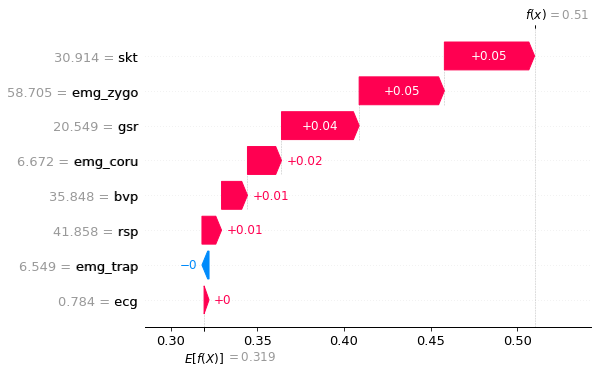

INSTANCE :  31
CLASS NAME  Confident or Attentive


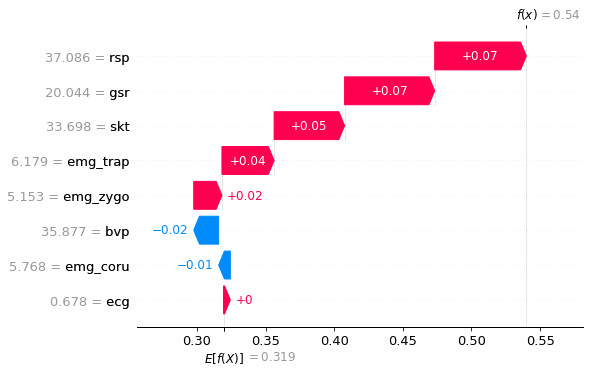

INSTANCE :  42
CLASS NAME  Confident or Attentive


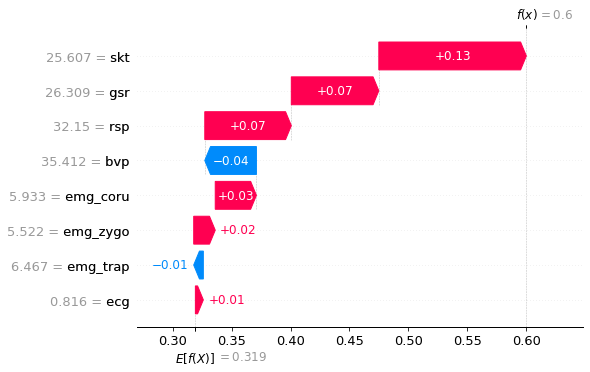

INSTANCE :  43
CLASS NAME  Confident or Attentive


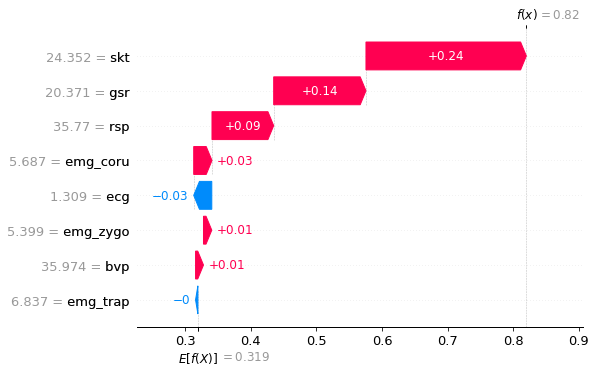

INSTANCE :  47
CLASS NAME  Confident or Attentive


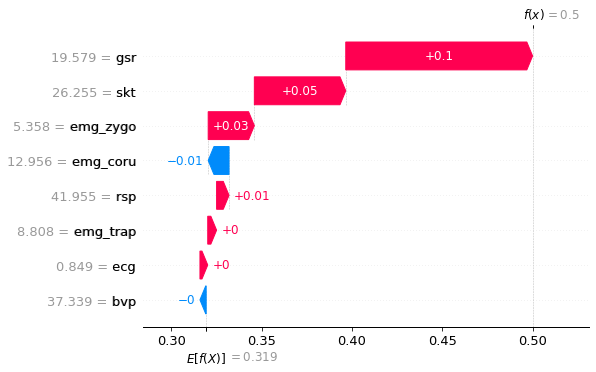

INSTANCE :  49
CLASS NAME  Confident or Attentive


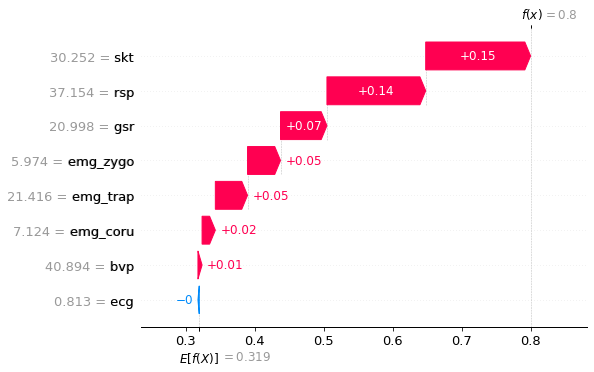

INSTANCE :  50
CLASS NAME  Confident or Attentive


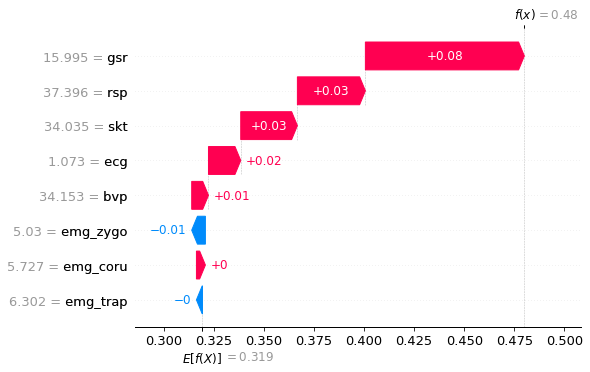

INSTANCE :  52
CLASS NAME  Confident or Attentive


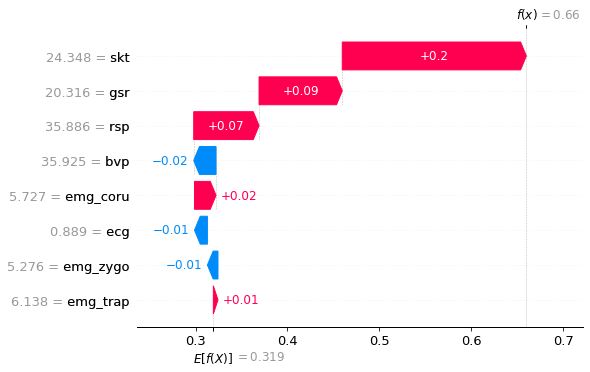

INSTANCE :  61
CLASS NAME  Confident or Attentive


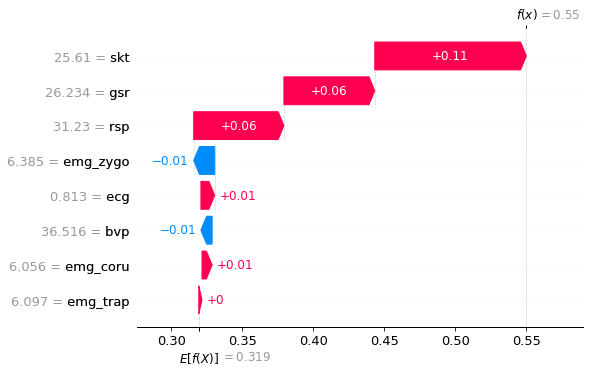

INSTANCE :  63
CLASS NAME  Confident or Attentive


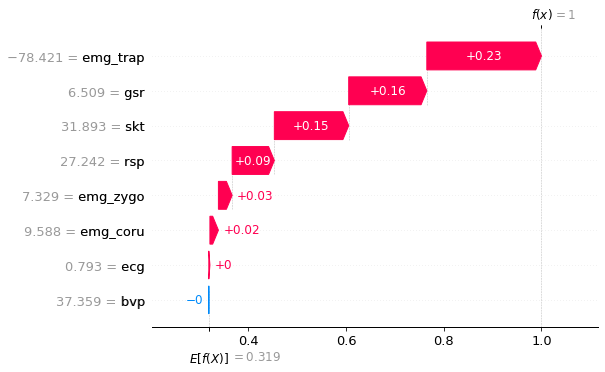

INSTANCE :  65
CLASS NAME  Confident or Attentive


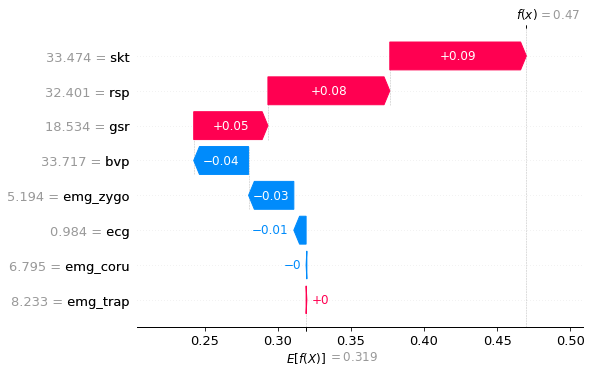

INSTANCE :  68
CLASS NAME  Confident or Attentive


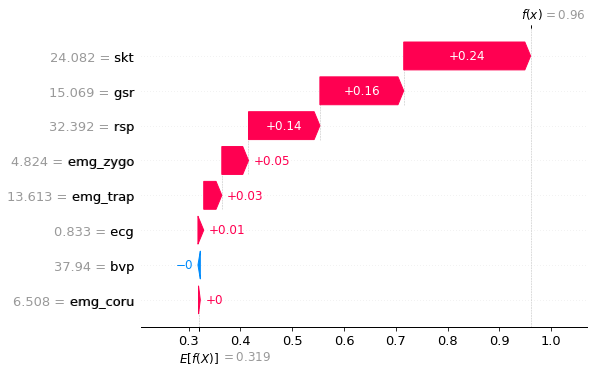

INSTANCE :  69
CLASS NAME  Confident or Attentive


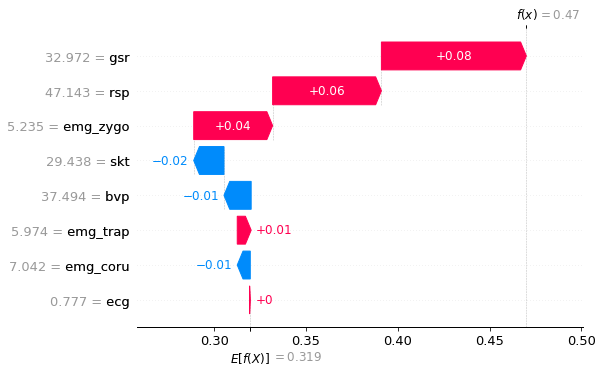

INSTANCE :  72
CLASS NAME  Confident or Attentive


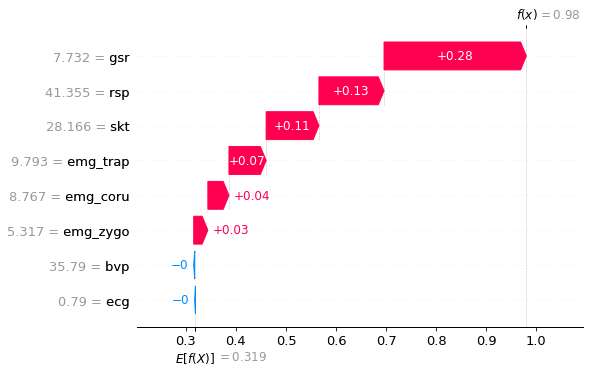

INSTANCE :  76
CLASS NAME  Confident or Attentive


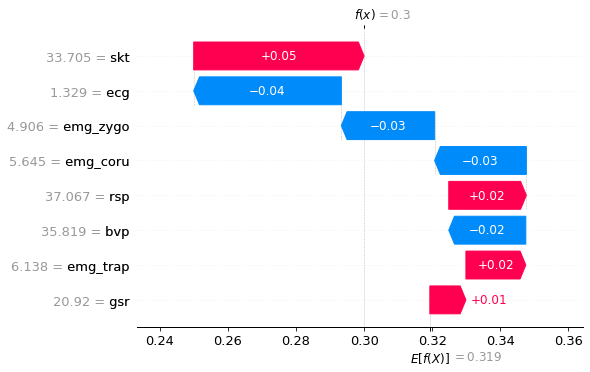

INSTANCE :  77
CLASS NAME  Confident or Attentive


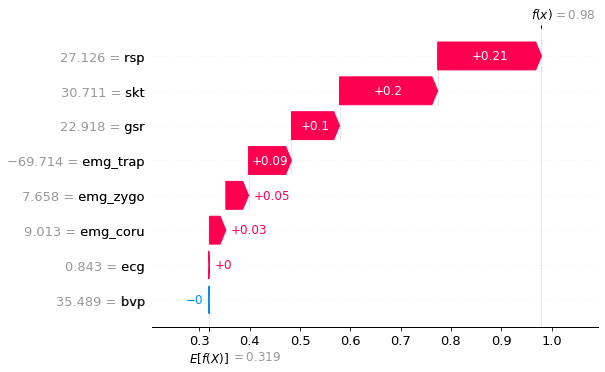

INSTANCE :  79
CLASS NAME  Confident or Attentive


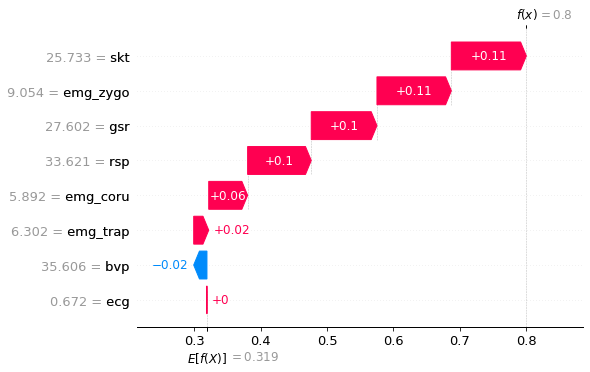

INSTANCE :  85
CLASS NAME  Confident or Attentive


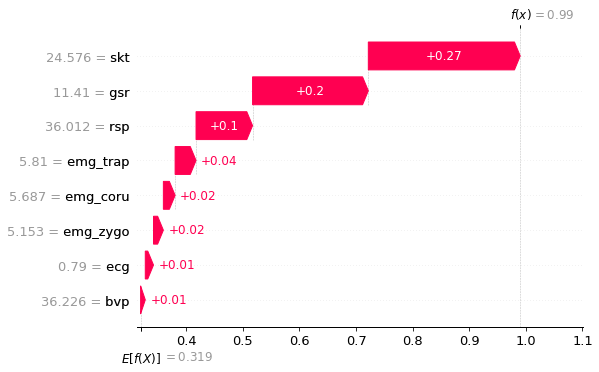

INSTANCE :  88
CLASS NAME  Confident or Attentive


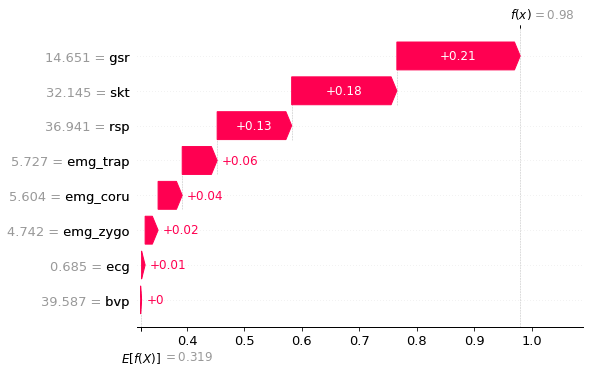

INSTANCE :  89
CLASS NAME  Confident or Attentive


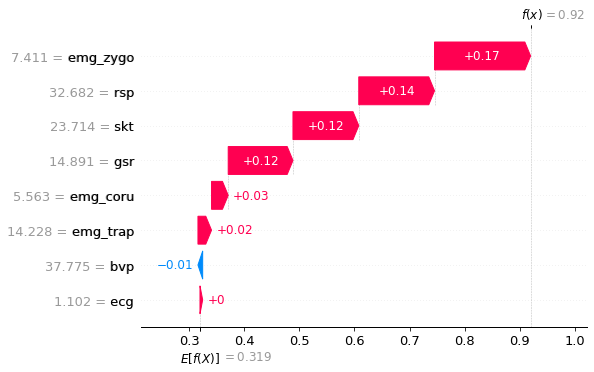

INSTANCE :  97
CLASS NAME  Confident or Attentive


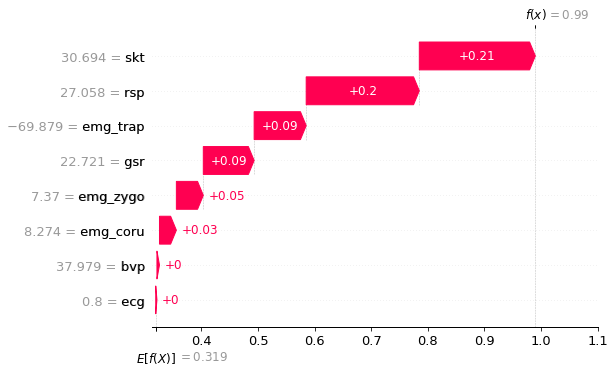

INSTANCE :  98
CLASS NAME  Confident or Attentive


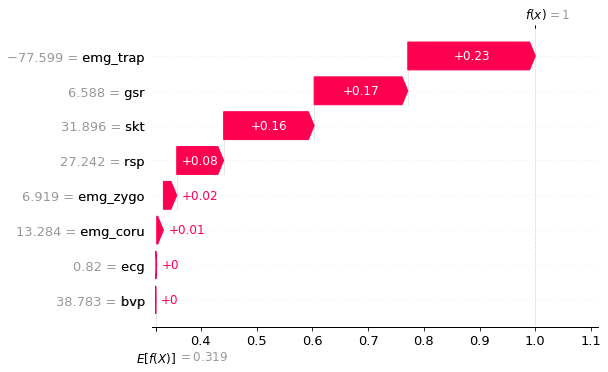

INSTANCE :  99
CLASS NAME  Confident or Attentive


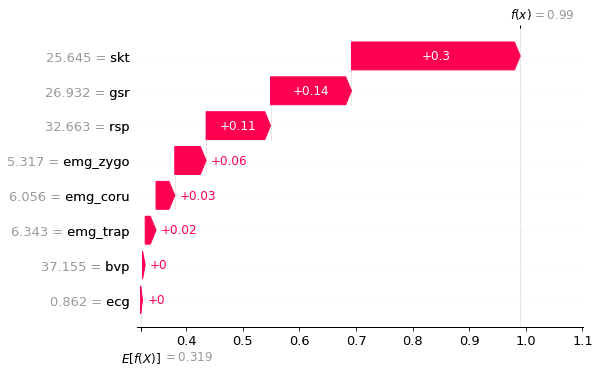

INSTANCE :  101
CLASS NAME  Confident or Attentive


IndexError: index 101 is out of bounds for axis 0 with size 100

In [33]:
for instance_index in instance_indices:
    class_name = 2
    print("INSTANCE : ",instance_index)
    print("CLASS NAME ", class_names[class_name])
    EXP = shap.Explanation(
        values=explanation[instance_index].values[:,class_name],
        base_values=explanation[instance_index].base_values[class_name],
        data = explanation[instance_index].data,
        feature_names = feature_names
    )
    shap.waterfall_plot(EXP,max_display = 8)

CLASS NAME  Anxious or Dejected


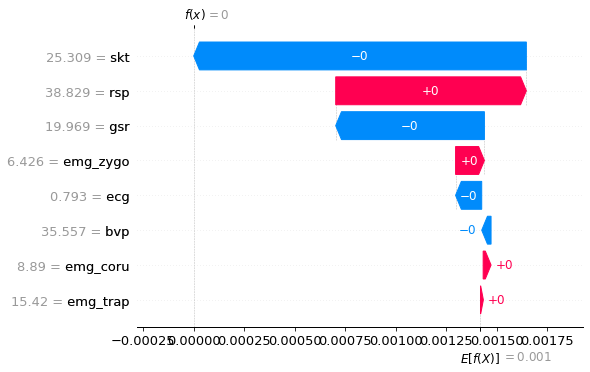

CLASS NAME  Aroused or Astonished


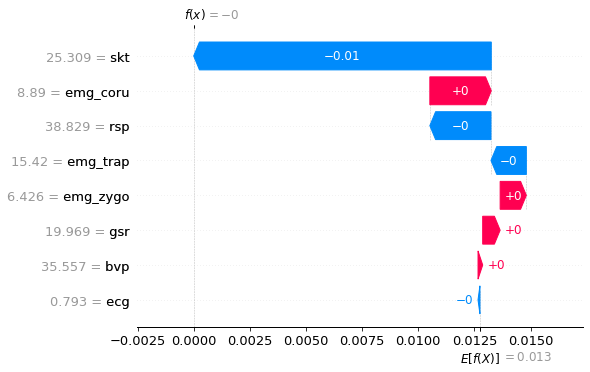

CLASS NAME  Confident or Attentive


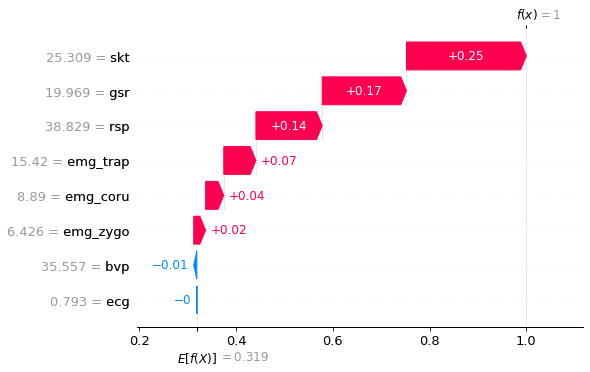

CLASS NAME  Delighted or Happy


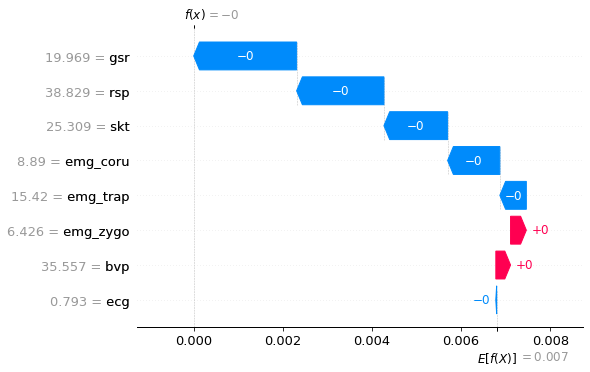

CLASS NAME  Distressed or Defiant


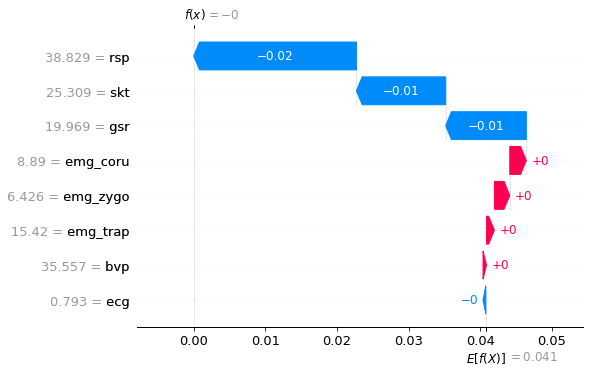

CLASS NAME  Frustrated or Discontented


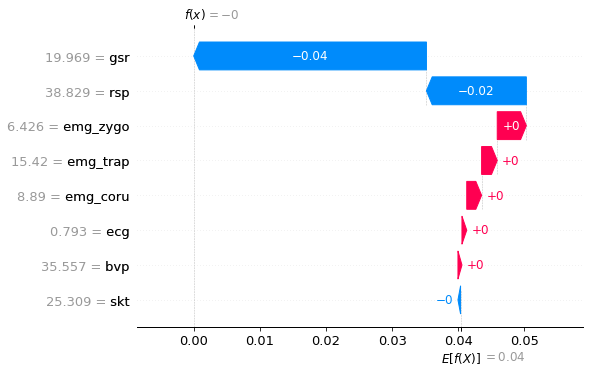

CLASS NAME  Frustrated or Impatient


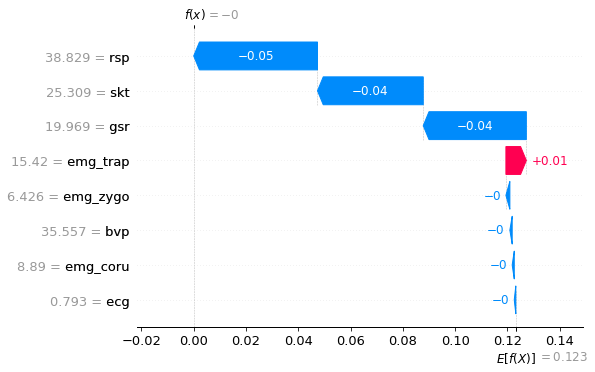

CLASS NAME  Miserable or Sad


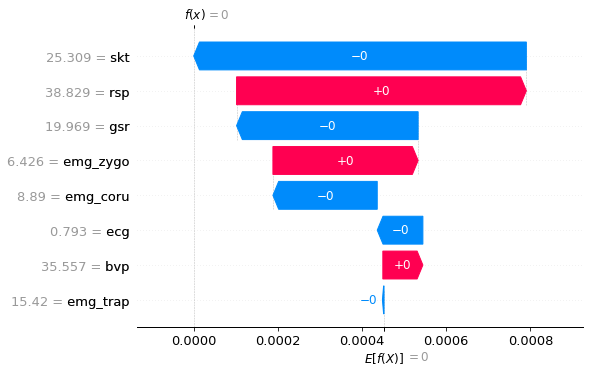

CLASS NAME  Passionate or Amused


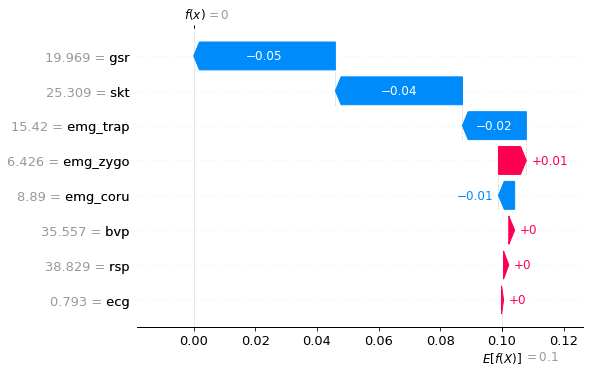

CLASS NAME  Pleased or Glad


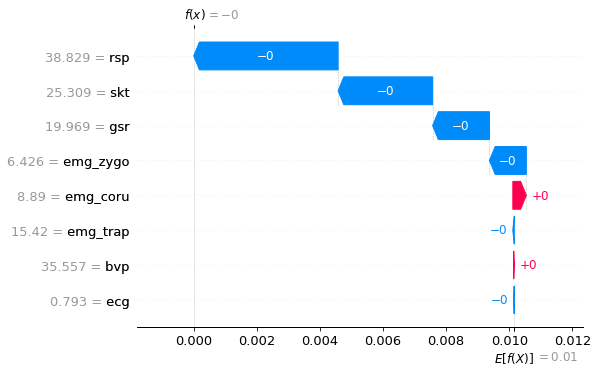

CLASS NAME  Polite or Sleepy


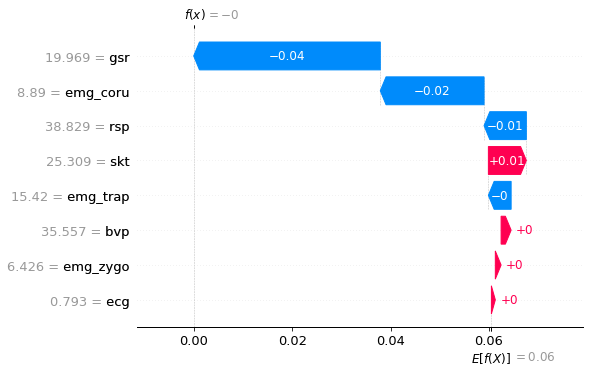

CLASS NAME  Tensed or Annoyed


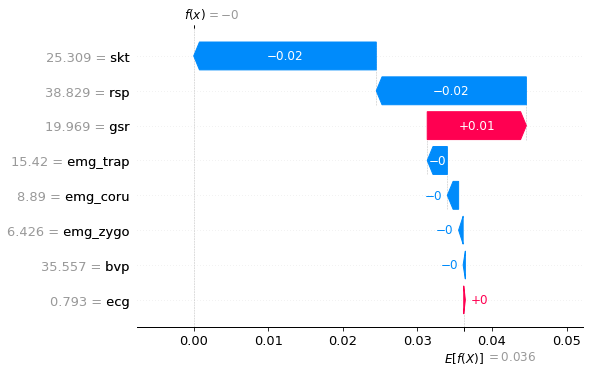

CLASS NAME  Tired or Bored


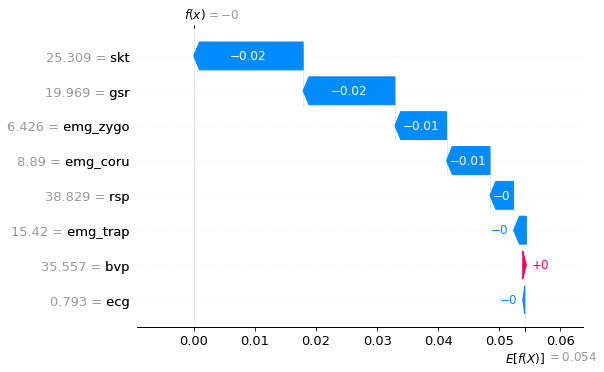

CLASS NAME  Worried or Apathetic


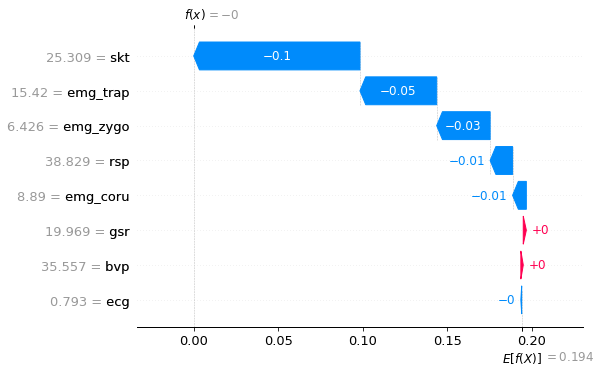

In [17]:
for i in range(len(class_names)):
    class_name = i
    print("CLASS NAME ", class_names[class_name])
    EXP = shap.Explanation(
        values=explanation[instance_index].values[:,class_name],
        base_values=explanation[instance_index].base_values[class_name],
        data = explanation[instance_index].data,
        feature_names = feature_names
    )
    shap.waterfall_plot(EXP,max_display = 8)

In [18]:
class_names[y_test[instance_index]]

'Confident or Attentive'

In [19]:
X_test.iloc[instance_index]

ecg          0.793480
bvp         35.557202
gsr         19.969344
rsp         38.828584
skt         25.308717
emg_zygo     6.425750
emg_coru     8.889750
emg_trap    15.419500
Name: 184605, dtype: float64

CLASS  Anxious or Dejected


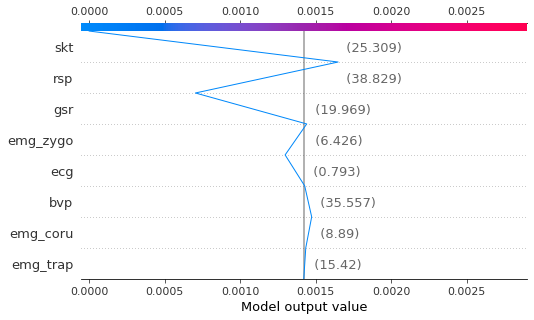

CLASS  Aroused or Astonished


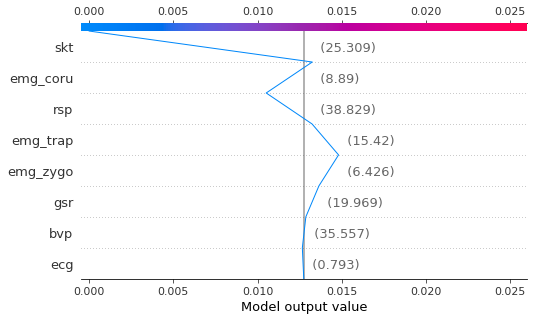

CLASS  Confident or Attentive


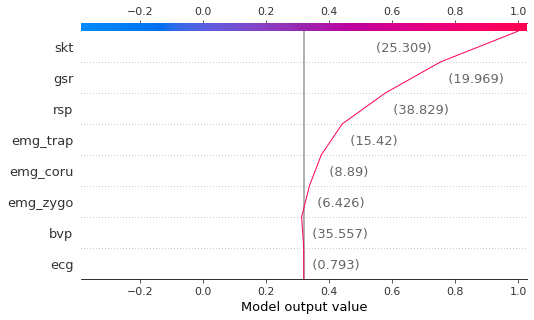

CLASS  Delighted or Happy


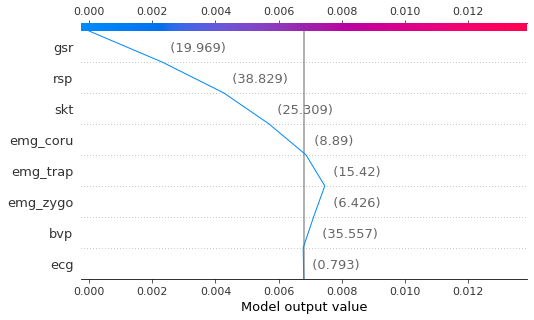

CLASS  Distressed or Defiant


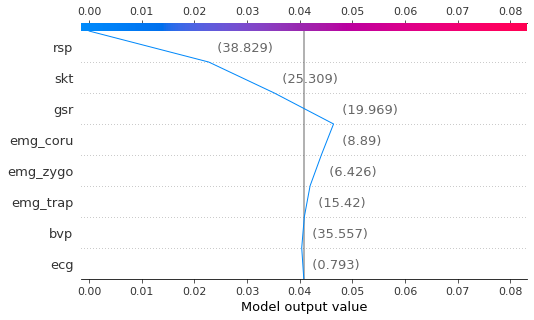

CLASS  Frustrated or Discontented


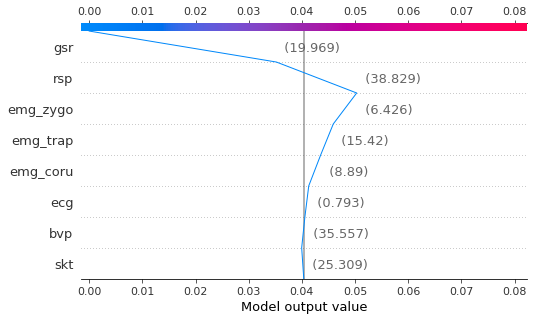

CLASS  Frustrated or Impatient


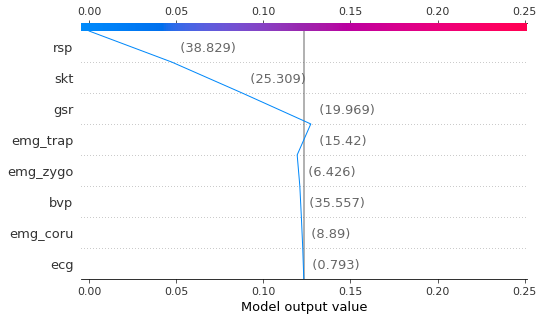

CLASS  Miserable or Sad


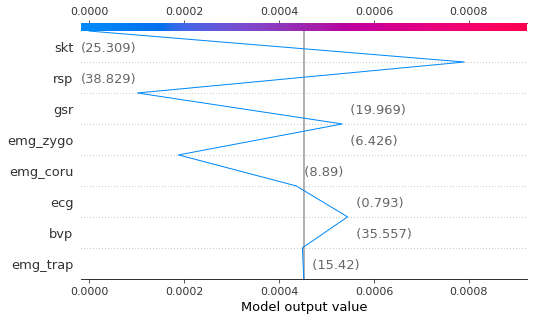

CLASS  Passionate or Amused


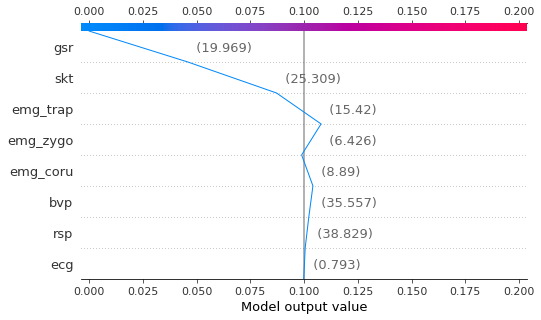

CLASS  Pleased or Glad


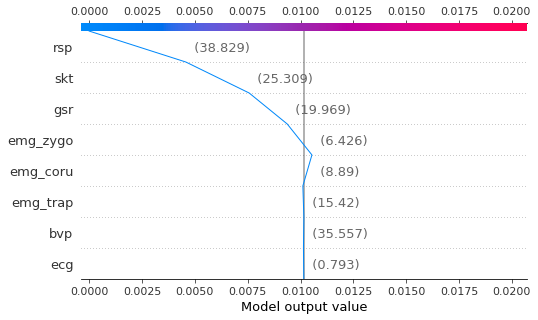

CLASS  Polite or Sleepy


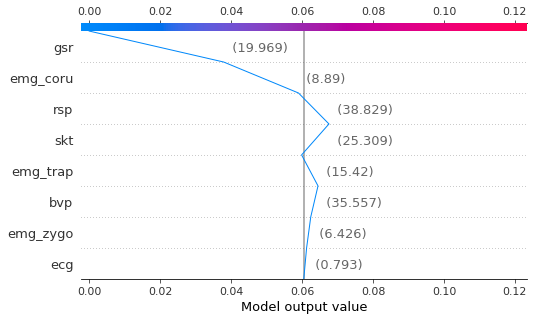

CLASS  Tensed or Annoyed


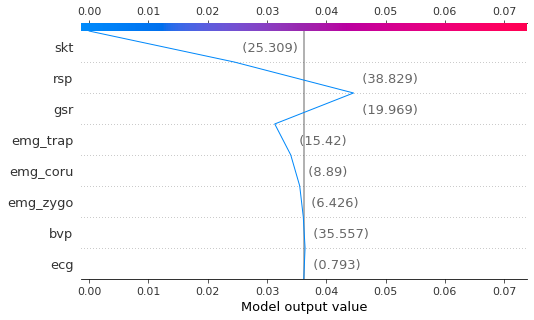

CLASS  Tired or Bored


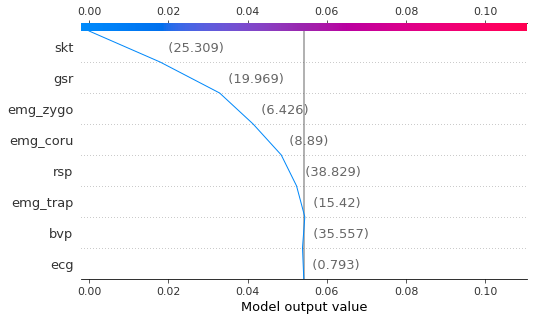

CLASS  Worried or Apathetic


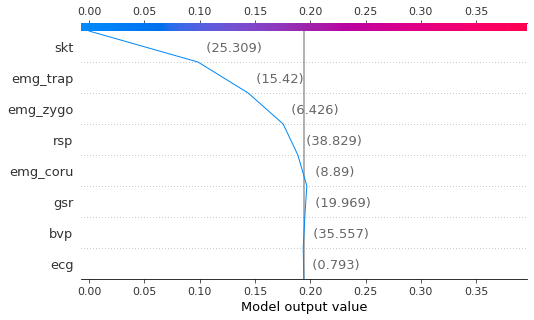

In [20]:
for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    shap.decision_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index], X_test.iloc[instance_index])

In [21]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, mode="classification",kernel_width=0.5)
t0 = time.time()

explanations_test = []

explanation_lime = explainer.explain_instance(
    X_test.values[instance_index], rf.predict_proba, num_features=10, top_labels=14)
explanations_test.append(explanation_lime)

t1 = time.time()
timeit = t1 - t0
print("TIME to interpret\n\n", timeit, "seconds")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


TIME to interpret

 9.742745399475098 seconds


In [22]:
explanation = explanations_test[0]
explanation.show_in_notebook()

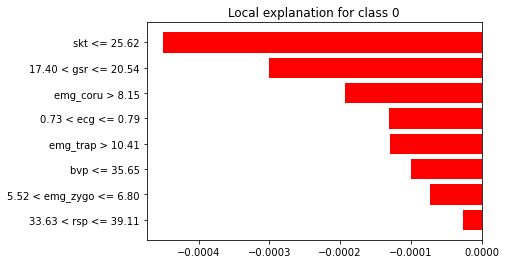

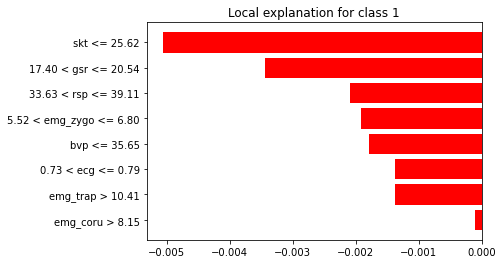

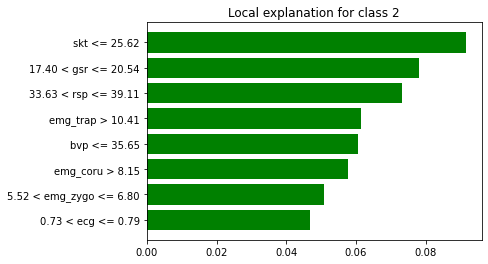

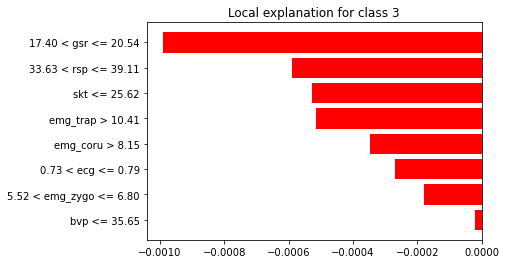

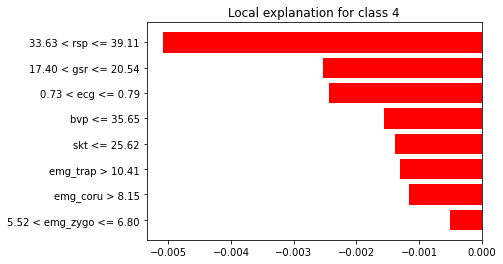

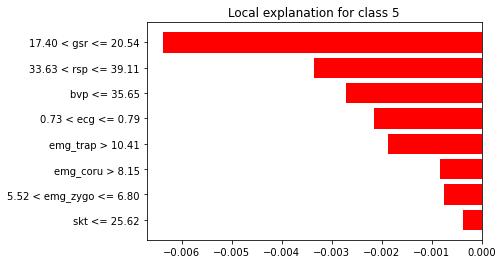

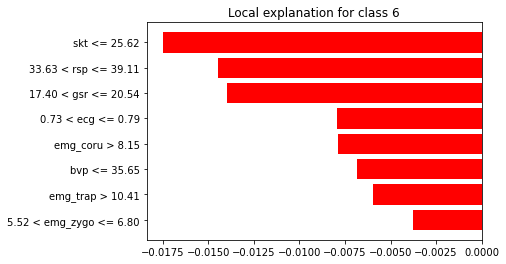

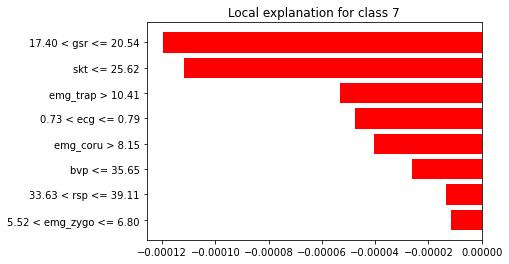

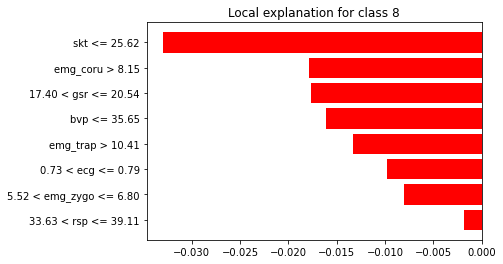

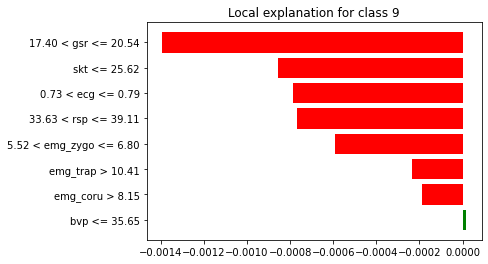

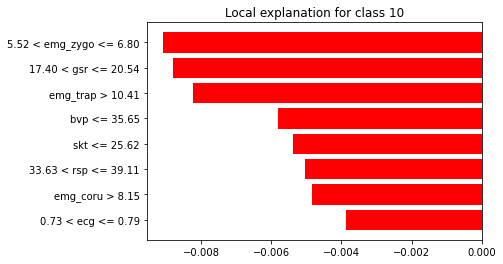

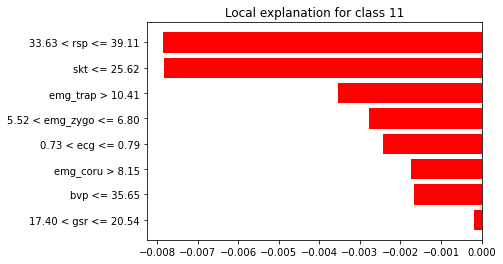

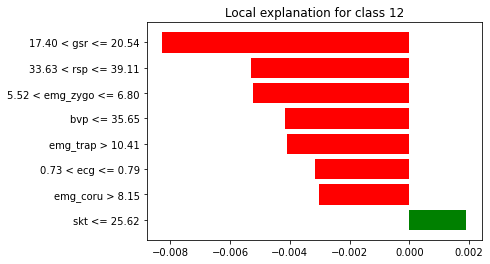

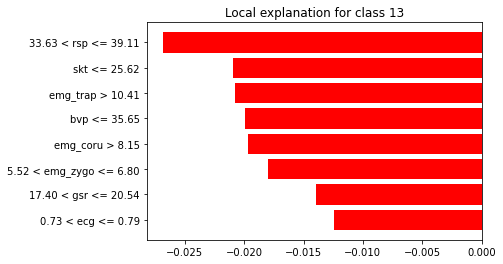

In [23]:
for i in range(len(encoded_classes)):
    explanation.as_pyplot_figure(label=i)

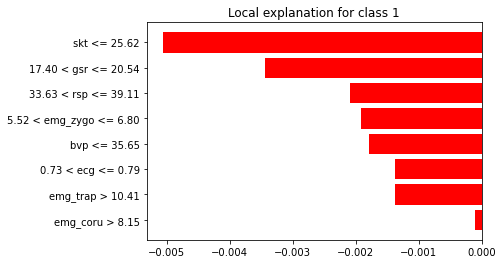

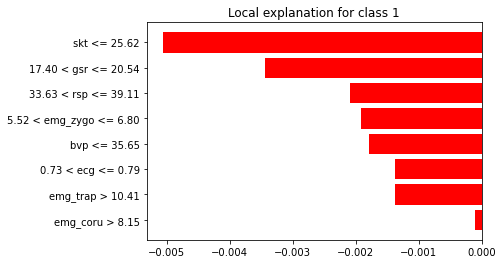

In [24]:
explanation.as_pyplot_figure(label=1)